In [32]:
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from keras.utils import np_utils
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN

## Train

> - 양손 + 거리값 + 정규화
> - loss: 0.0264 - accuracy: 0.9985 - val_loss: 0.3806 - val_accuracy: 0.8957

### 1) train, test data 준비

In [5]:
input_path = 'output_text'

train_files = []
train_categories=[]

word_list = os.listdir(input_path) 

for word in word_list:
    if word == '.ipynb_checkpoints':
        continue
    text_list = os.listdir(input_path +'/'+ word)
    for file_name in text_list:
        train_files.append(input_path +'/'+ word + '/' + file_name)
        train_categories.append(word)

train_data = pd.DataFrame(
            {'file' : train_files,
             'label': train_categories  
            })
display(train_data.head())
train_df, valid_df = train_test_split(train_data, test_size=0.2,
                                     random_state=42, stratify=train_data['label'])

,file,label
0,output_text/0/WIN_20201217_18_56_05_Pro.txt,0
1,output_text/0/KETI_SL_0000004610.txt,0
2,output_text/0/WIN_20201217_18_54_55_Pro.txt,0
3,output_text/0/WIN_20201217_18_15_49_Pro.txt,0
4,output_text/0/WIN_20201217_18_15_51_Pro.txt,0


### 2) train/test data x, y 분리
- x 데이터에는 프레임 단위로, 좌표끼리의 거리값을 계산하여 정규화 후 사용한다.
- y 데이터에는 수어 손동작의 뜻을 입력한다.

In [31]:
# 좌표간 거리 계산 함수
def get_distance(row):
    left = row[0:42]
    right = row[42:]
    dlist = []
    for i in range(0, len(left), 2):
        for j in range(i+2, len(left), 2):
            x1 = left[i]
            x2 = left[i+1]
            y1 = left[j]
            y2 = left[j+1]
            dlist.append(math.hypot(x2-x1, y2-y1))
    for i in range(0, len(right), 2):
        for j in range(i+2, len(right), 2):
            x1 = right[i]
            x2 = right[j]
            y1 = right[i+1]
            y2 = right[j+1]
            dlist.append(math.hypot(x2-x1, y2-y1))
    return dlist

In [6]:
# x_train, y_train 생성
x_train = []
y_train = [] # label

scaler = MinMaxScaler()
for file_name in train_df['file']:
    with open(file_name, mode = 'r') as f:
        numbers = [float(num[:-1]) for num in f.read().split()]
    ex = np.array(numbers).reshape(-1, 84)
    distance_list = []
    for row in range(len(ex)):
        distance = get_distance(ex[row].tolist()) # 1 프레임
        distance2 = np.array(distance).reshape(-1,1)
        scaler.fit(distance2)
        distance2 = scaler.transform(distance2)
        distance2 = distance2.reshape(1,-1)[0]
        distance_list.extend(distance2.tolist())   
    x_train.append(distance_list)
    
for word_label in train_df['label']:
    y_train.append(word_label)
    
print(np.array(x_train).shape) 
print(np.array(y_train).shape)

(652,)
(652,)


In [7]:
# x_test, y_test 생성
x_test = [] 
y_test = [] # label

scaler = MinMaxScaler()
for file_name in valid_df['file']:
    with open(file_name, mode = 'r') as f:
        numbers = [float(num[:-1]) for num in f.read().split()]
    ex = np.array(numbers).reshape(-1, 84)
    distance_list = []
    for row in range(len(ex)):
        distance = get_distance(ex[row].tolist()) # 1 프레임
        distance2 = np.array(distance).reshape(-1,1)
        scaler.fit(distance2)
        distance2 = scaler.transform(distance2)
        distance2 = distance2.reshape(1,-1)[0]
        distance_list.extend(distance2.tolist())   
    x_test.append(distance_list)                  
    
for word_label in valid_df['label']:
    y_test.append(word_label)

print(np.array(x_test).shape) 
print(np.array(y_test).shape)

(163,)
(163,)


### 3) Tokenizer  & One-hot encoding

In [8]:
# Tokenizer 
y_set = set(y_train)
y_set = sorted(y_set)
text = ""
for i in y_set:
    text = text + str(i) + " "

print(text)

tk = Tokenizer()
tk.fit_on_texts([text]) # Tokenizer에 실제 데이터 입력
print(tk.word_index)

category = list(y_set)
print(category)
# ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '계획', '날씨', '뉴스', '도움', '시작1', '시작2', '일']
# one-hot encoding 이후에는, category list의 맨 앞에 다른 값을 채워 index 순서를 맞춘다.

0 1 2 3 4 5 6 7 8 9 계획 날씨 뉴스 도움 시작1 시작2 일 
{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, '계획': 11, '날씨': 12, '뉴스': 13, '도움': 14, '시작1': 15, '시작2': 16, '일': 17}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '계획', '날씨', '뉴스', '도움', '시작1', '시작2', '일']


In [14]:
y_train_encoded = tk.texts_to_sequences([y_train])[0] # 문장을 입력받아 숫자를 반환
y_test_encoded = tk.texts_to_sequences([y_test])[0]

y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

print(y_test[0])
print(y_test_one_hot[0]) # one-hot encoding

시작1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### 4) Zero-Padding

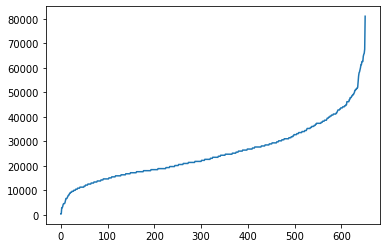

420
81060
25468


In [16]:
# x 데이터 파일마다 프레임 길이가 다르다.
x_train_data_len = [len(x_train_data) for x_train_data in x_train]
x_train_data_len.sort()
plt.plot(x_train_data_len)
plt.show()

print(min(x_train_data_len))
print(max(x_train_data_len))
print(sum(x_train_data_len)//len(x_train_data_len)) # 평균

del x_train_data_len

In [20]:
# x 데이터 크기 맞추기
# x_train의 최대 프레임 길이로 zero-padding
x_train_same_size = pad_sequences(x_train, dtype='float32')
max_len = len(x_train_same_size[-1])
x_test_same_size = pad_sequences(x_test, dtype='float32', maxlen=max_len)

frame_num = max_len//420
print(frame_num)

193


x_train_data_len


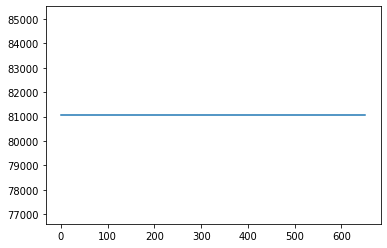

x_test_data_len


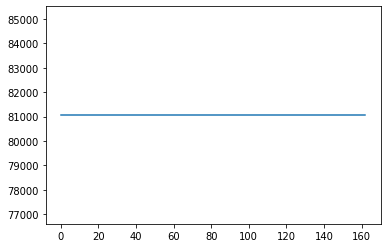

In [23]:
# 이제 x_train, x_test 길이가 모두 균일하다.

print('x_train_data_len')
x_train_data_len = [len(x_train_data) for x_train_data in x_train_same_size]
x_train_data_len.sort()
plt.plot(x_train_data_len)
plt.show()
del x_train_data_len

print('x_test_data_len')
x_test_data_len = [len(x_test_data) for x_test_data in x_test_same_size]
x_test_data_len.sort()
plt.plot(x_test_data_len)
plt.show()

### 4) LSTM 학습을 위해 3차원으로 변환하기
- (데이터 개수인 batch_size, 프레임 길이인 timesteps, 한 프레임 당 거리값 개수인 input_dim 순서)
- 한 손에는 21개의 좌표가 있다.
- 각 좌표간 10개의 손가락과의 거리를 계산하여 210개의 거리값 * 2 (양손) => 420이 input_dim에 해당한다.

In [27]:
x_train = x_train_same_size.reshape(x_train_same_size.shape[0], -1, 420)
x_test = x_test_same_size.reshape(x_test_same_size.shape[0], -1, 420)

y_train = y_train_one_hot
y_test = y_test_one_hot
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

del x_train_same_size
del x_test_same_size
del y_train_one_hot
del y_test_one_hot

(652, 193, 420)
(652, 18)
(163, 193, 420)
(163, 18)


In [28]:
a = x_train.shape[1]
b = x_train.shape[2]
# input shape will be (a, b)
print(a, b)

193 420


### 5) LSTM 학습
- LSTM layer 2개 사용
- LSTM layer 3개를 사용할 경우, 정확도가 높아질 것이라 예측했지만 실제로 큰 차이는 없었다.
- 따라서 layer 2개의 LSTM 모델이, 서비스화 했을 때의 예측값 응답 시간이 짧아 최종 모델로 적합하다고 판단했다.

In [29]:
## Layer 2, epoch 71
# loss: 0.0264 - accuracy: 0.9985 - val_loss: 0.3806 - val_accuracy: 0.8957

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니s다
        print(e)

with tf.device('/device:GPU:0'): 
    # 모델 정의 하기
    label = y_train.shape[1]

    model = Sequential()
    model.add(LSTM(64, return_sequences=True,
                   input_shape=(a, b))) 
    model.add(LSTM(32))
    model.add(Dense(label, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    print('Training stage')
    print('==============')
    history = model.fit(x_train,
                        y_train,
                        epochs = 71,
                        batch_size = 16,
                        validation_data = (x_test, y_test))
    score, acc = model.evaluate(x_test, y_test, batch_size = 16, verbose=0)
    print('Test performance: accuracy={0}, loss={1}'.format(acc, score))
    model.save('LSTM_layer2_71epochs.h5') 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 193, 64)           124160    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 18)                594       
Total params: 137,170
Trainable params: 137,170
Non-trainable params: 0
_________________________________________________________________
Training stage
Epoch 1/71
41/41 [==============================] - 1s 34ms/step - loss: 2.6593 - accuracy: 0.1687 - val_loss: 2.3851 - val_accuracy: 0.2822
Epoch 2/71
41/41 [==============================] - 1s 16ms/step - loss: 2.2067 - accuracy: 0.3328 - val_loss: 2.0779 - val_accuracy: 0.3620
Epoch 3/71
41/41 [==============================] - 1s 17ms/step - loss: 1.8612 - a